In [1]:
%load_ext autoreload
%autoreload 2

# Análisis de Precios de Vivienda en Chile con Machine Learning

## Justificación y Objetivos
Tenemos un dataset con 40 columnas que tienen información relacionada a 31652 viviendas en Chile.

Me gustaría realizar un modelo que prediga el ingreso mensual de un hogar, dada su situación particular. Esto principalmente porque es un análisis directo, con muchas implicancias asociadas a la desigualdad nacional y porque personalmente quiero entender mejor las relaciones que pueden exisitir.

Para hacer este análisis decidí usar el modelo CATBOOST. He escuchado comentarios muy positiovs y ya llevo bastante tiempo queriendo usarlo. Por supuesto también es un modelo con una buena reputación para trabajr con información tabular y categorica. Lo único que me lamento es no tener un dataset mas grande.

## Definición del problema

Predecir el ingreso_mensual_hogar basándose en un conjunto de características de la vivienda, demográficas del hogar y su ubicación geográfica.

Hipótesis o Preguntas de Investigación

Hipótesis 1 (Capital Humano): El nivel educativo del jefe de hogar (jefe_hogar_educacion) es uno de los predictores más importantes del ingreso del hogar. Se espera una correlación positiva fuerte.

Hipótesis 2 (Ubicación Geográfica): La comuna donde se ubica la vivienda es un factor determinante del ingreso, reflejando disparidades económicas territoriales en Chile. Comunas como 'Providencia' o 'Ñuñoa' probablemente se asociarán con ingresos más altos.

Hipótesis 3 (Calidad de la Vivienda): Características como la superficie_m2, el número de baños (num_banos) y los materiales de construcción (material_paredes, material_techo) están positivamente correlacionados con el ingreso.

Pregunta de Investigación: Más allá de las variables obvias, ¿qué otros factores, como la tenencia de la vivienda (tenencia_vivienda) o el acceso a servicios (internet, gas_natural), tienen un poder predictivo significativo sobre el ingreso?


## EDA

In [2]:

# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from data_observatory_test_062025.load_data_viviendas import load_interim_data
from data_observatory_test_062025.generic_eda_report import generic_report

# 2. Configurar estilo de gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 3. Cargar el dataset limpio de la Pregunta 2
try:
    df_limpio = load_interim_data()
    print("Dataset limpio cargado exitosamente.")
except FileNotFoundError:
    print("Error: Ejecute primero la Pregunta 2 para generar 'datos_viviendas_censo_limpio.csv'")
    exit()

2025-06-06 00:57:11.203 | INFO     | data_observatory_test_062025.config:<module>:11 - PROJ_ROOT path is: /var/home/felipecabello/git/data_observatory_test_062025


Dataset limpio cargado exitosamente.


In [3]:
# Lo primero es dejar como referencia al tope del archivo una descripción general del dataset

# Me llama la atención esa variable "Unnamed:0", parece que se coló un índice extra jaja

generic_report(df_limpio)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31652 entries, 0 to 31651
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          31652 non-null  int64  
 1   id_vivienda                         31652 non-null  object 
 2   comuna                              31652 non-null  object 
 3   tipo_vivienda                       31652 non-null  object 
 4   num_dormitorios                     31652 non-null  int64  
 5   num_banos                           31652 non-null  int64  
 6   superficie_m2                       31652 non-null  float64
 7   ano_construccion                    31652 non-null  int64  
 8   material_paredes                    31652 non-null  object 
 9   material_techo                      31652 non-null  object 
 10  num_personas_hogar                  31652 non-null  int64  
 11  num_hombres                         31652

Text(0, 0.5, 'Frecuencia')

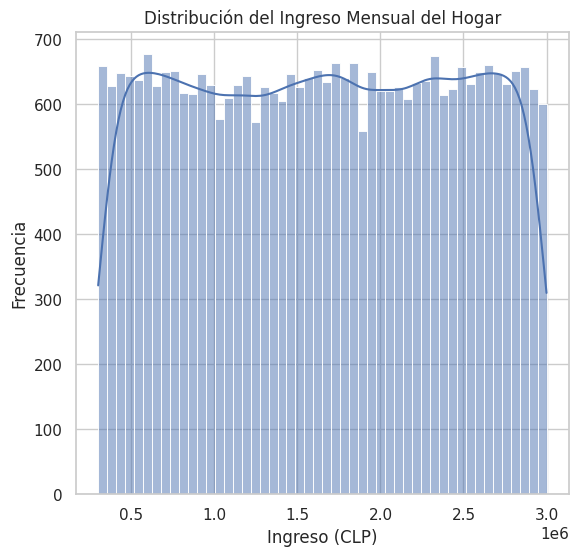

In [4]:

# 1. Visualización de la variable objetivo: Ingreso Mensual del Hogar
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_limpio['ingreso_mensual_hogar'], kde=True, bins=50)
plt.title('Distribución del Ingreso Mensual del Hogar')
plt.xlabel('Ingreso (CLP)')
plt.ylabel('Frecuencia')



** La distribución de ingresos casi siempre está sesgada. Este dataset parece haber tomado una muestra mas uniforme. el dataset no representa la totalidad del espectro de ingresos en Chile. Pero tenemos una muestra mas uniforme **


In [5]:
df_limpio['ingreso_mensual_hogar'].describe()

count    3.165200e+04
mean     1.650400e+06
std      7.822275e+05
min      3.000390e+05
25%      9.666398e+05
50%      1.654124e+06
75%      2.331114e+06
max      2.999967e+06
Name: ingreso_mensual_hogar, dtype: float64

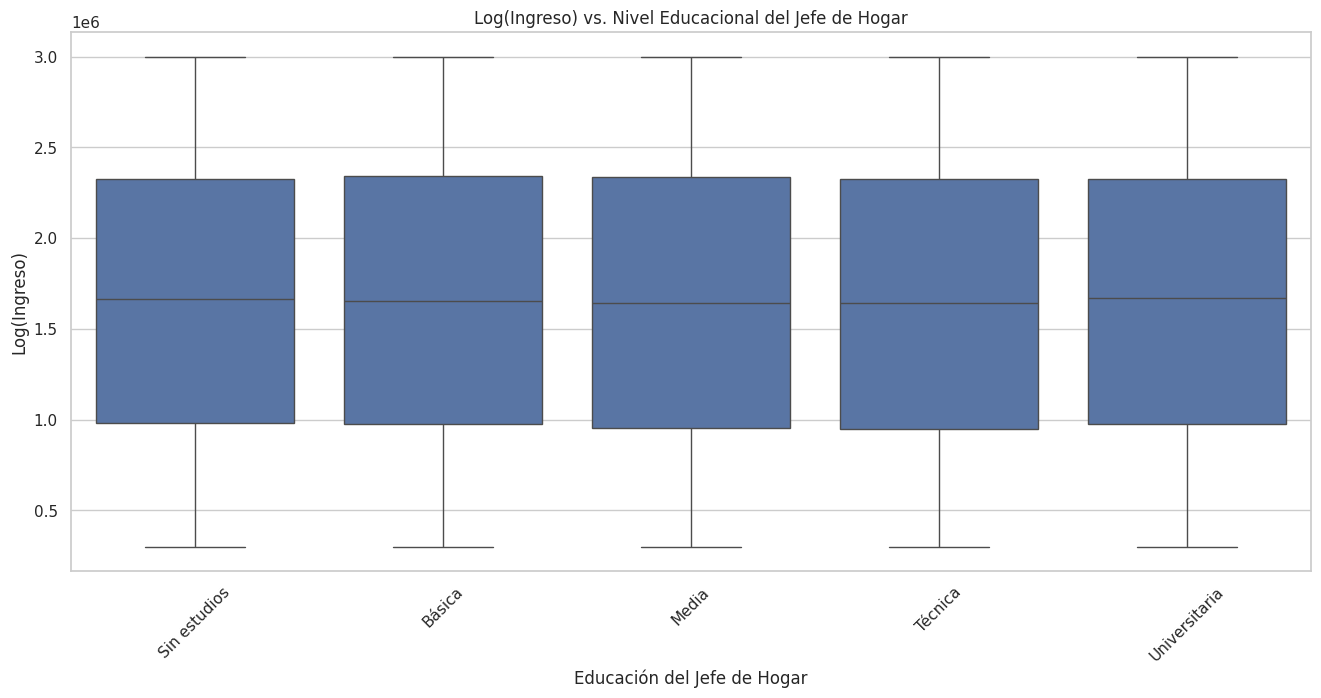

In [6]:
# 2. Relación entre variables categóricas clave y el ingreso
plt.figure(figsize=(16, 7))
sns.boxplot(x='jefe_hogar_educacion', y='ingreso_mensual_hogar', data=df_limpio,
            order=['Sin estudios', 'Básica', 'Media', 'Técnica', 'Universitaria'])
plt.title('Log(Ingreso) vs. Nivel Educacional del Jefe de Hogar')
plt.xlabel('Educación del Jefe de Hogar')
plt.ylabel('Log(Ingreso)')
plt.xticks(rotation=45)
plt.show()

Todo es bastante regular, es muy descorcentante trabajar con información tan artificial.


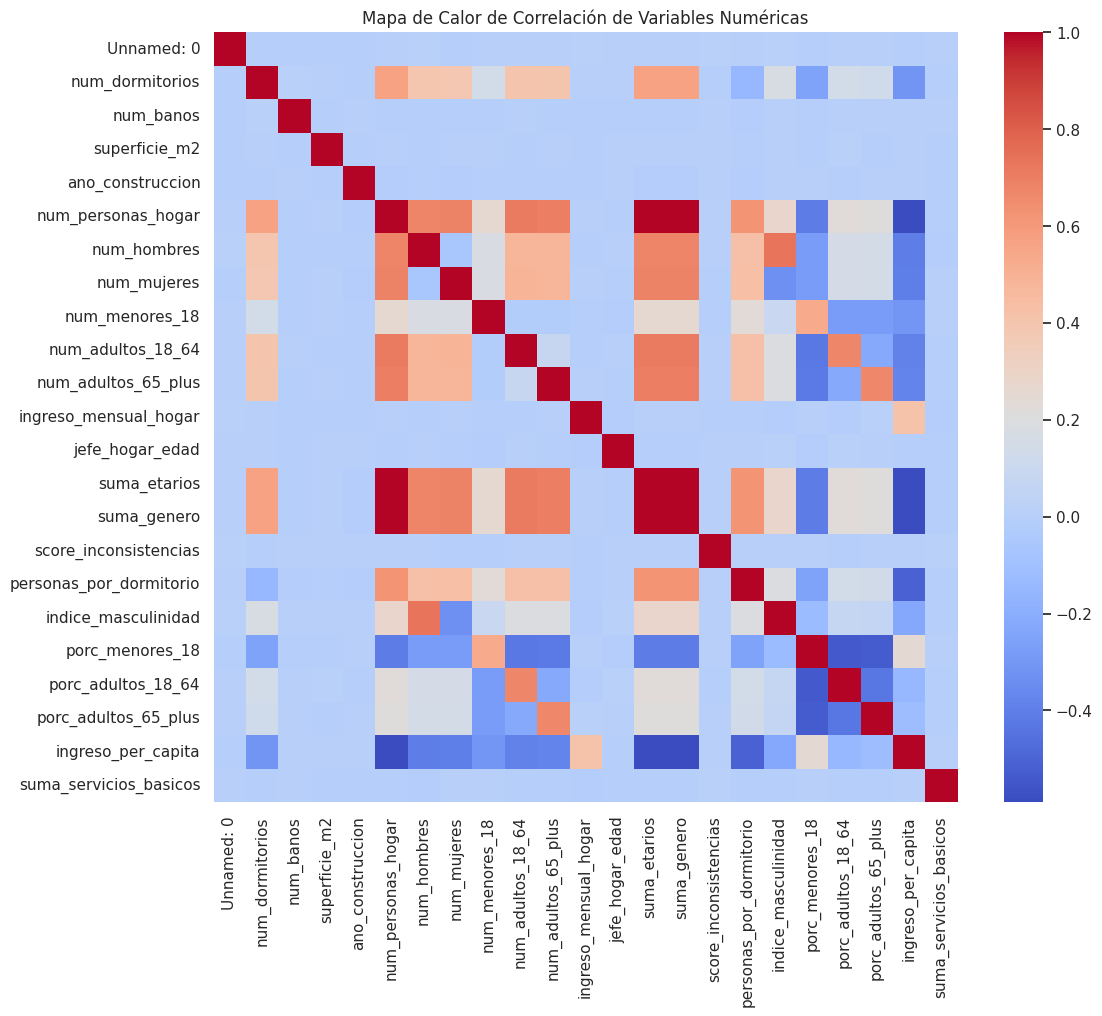

In [7]:
numeric_cols = df_limpio.select_dtypes(include=np.number).columns
plt.figure(figsize=(12, 10))
correlation_matrix = df_limpio[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación de Variables Numéricas')
plt.show()

In [15]:
df_limpio[numeric_cols].corr()

,num_dormitorios,num_banos,superficie_m2,ano_construccion,num_personas_hogar,num_hombres,num_mujeres,num_menores_18,num_adultos_18_64,num_adultos_65_plus,ingreso_mensual_hogar,jefe_hogar_edad,score_inconsistencias,personas_por_dormitorio,porc_menores_18,porc_adultos_18_64,porc_adultos_65_plus,suma_servicios_basicos
num_dormitorios,1.000000,0.007261,0.004936,-0.002046,0.571090,0.394387,0.386636,0.138416,0.407860,0.401513,0.004300,0.001876,-0.005840,-0.144546,-0.248648,0.138392,0.126839,-0.006002
num_banos,0.007261,1.000000,-0.005820,0.001926,-0.001902,-0.001219,-0.001381,-0.003479,0.000617,-0.002066,-0.003930,-0.001842,0.001953,-0.010504,-0.001785,0.000951,0.000953,0.001880
superficie_m2,0.004936,-0.005820,1.000000,-0.005461,0.001056,-0.002099,0.003536,0.003468,-0.000744,0.000905,-0.001571,0.000776,0.004695,-0.005702,-0.004913,0.008734,-0.003529,-0.002097
ano_construccion,-0.002046,0.001926,-0.005461,1.000000,-0.006152,-0.001183,-0.007222,-0.005562,-0.005087,-0.001898,-0.003241,0.001921,0.002285,-0.006906,0.001725,-0.004765,0.002947,-0.004977
num_personas_hogar,0.571090,-0.001902,0.001056,-0.006152,1.000000,0.682735,0.684845,0.258189,0.709847,0.700772,0.003063,-0.001507,0.001523,0.625816,-0.411408,0.225413,0.213455,-0.004702
num_hombres,0.394387,-0.001219,-0.002099,-0.001183,0.682735,1.000000,-0.064861,0.176562,0.483837,0.479132,-0.001117,0.002374,0.003811,0.425130,-0.280702,0.153401,0.146040,-0.007451
num_mujeres,0.386636,-0.001381,0.003536,-0.007222,0.684845,-0.064861,1.000000,0.176533,0.486933,0.479231,0.005297,-0.004427,-0.001720,0.430718,-0.281931,0.154868,0.145878,0.001010
num_menores_18,0.138416,-0.003479,0.003468,-0.005562,0.258189,0.176562,0.176533,1.000000,-0.014270,-0.013394,-0.000744,-0.007897,-0.005038,0.233363,0.530520,-0.284074,-0.281895,0.000693
num_adultos_18_64,0.407860,0.000617,-0.000744,-0.005087,0.709847,0.483837,0.486933,-0.014270,1.000000,0.077242,-0.000936,0.005776,0.001824,0.426736,-0.425709,0.672691,-0.221206,-0.004685
num_adultos_65_plus,0.401513,-0.002066,0.000905,-0.001898,0.700772,0.479132,0.479231,-0.013394,0.077242,1.000000,0.005955,-0.004831,0.002611,0.425948,-0.421989,-0.217817,0.670668,-0.002734


In [8]:
df_limpio = df_limpio.drop(columns=['Unnamed: 0', 'id_vivienda', 'ingreso_per_capita', 'indice_masculinidad']) # No queremos data leakage 
# Las columnas 'suma_genero' y 'suma_etarios' parecen ser validaciones de consistencia.
# Si num_personas_hogar == num_hombres + num_mujeres, entonces suma_genero es redundante.
# Las eliminamos para evitar multicolinealidad perfecta.
df_limpio = df_limpio.drop(columns=['suma_genero', 'suma_etarios'])

# 3. Verificar si hay otros outliers o inconsistencias
# Podríamos explorar las viviendas con scores altos si el modelo tiene mal rendimiento.
# Por ahora, confiamos en que los árboles de CatBoost manejarán bien los outliers.

# 4. Definir las variables predictoras (X) y la objetivo (y)
y = df_limpio['ingreso_mensual_hogar']
X = df_limpio.drop(columns=['ingreso_mensual_hogar'])

# 5. Identificar las variables categóricas para CatBoost
categorical_features_indices = [X.columns.get_loc(c) for c in X.select_dtypes(include=['object', 'bool']).columns]

print(f"Columnas categóricas identificadas: {X.select_dtypes(include=['object', 'bool']).columns.tolist()}")

Columnas categóricas identificadas: ['comuna', 'tipo_vivienda', 'material_paredes', 'material_techo', 'jefe_hogar_sexo', 'jefe_hogar_educacion', 'agua_potable', 'electricidad', 'gas_natural', 'internet', 'telefono_fijo', 'vehiculo_propio', 'tenencia_vivienda', 'Departamento_madera_flag', 'MediaAgua_Hormigon_flag', 'Departamento_techo_paja_flag', 'Casa_pareada_techo_paja_flag', 'techo_rustico_paredes_premium_flag', 'media_agua_losa_flag', 'losa_adobe_flag']


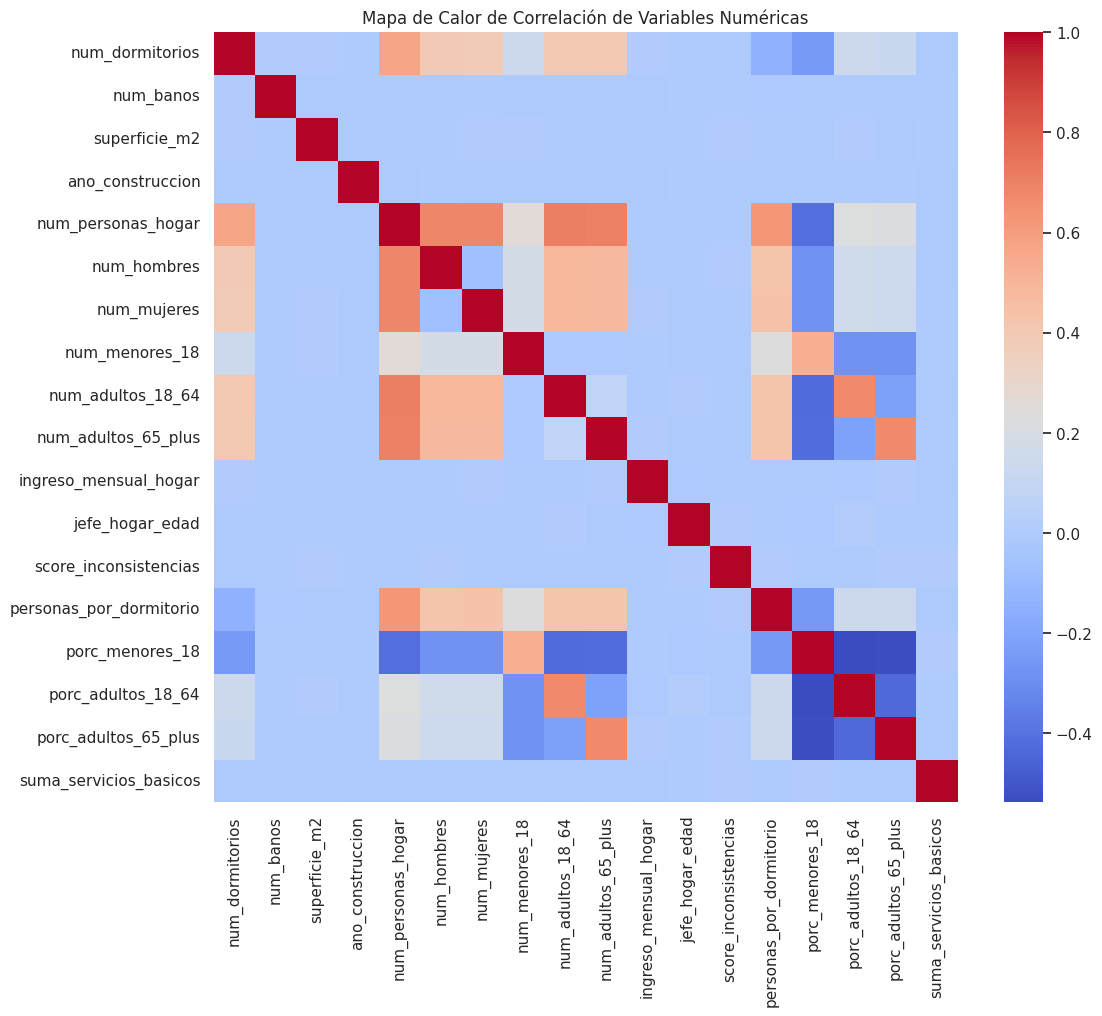

In [9]:
numeric_cols = df_limpio.select_dtypes(include=np.number).columns
plt.figure(figsize=(12, 10))
correlation_matrix = df_limpio[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación de Variables Numéricas')
plt.show()

Ahora hay menos colinealidad

## Implementación



In [10]:
# Dividir los datos en conjuntos de entrenamiento y prueba para la evaluación final
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Implementación con Validación Cruzada ---
# Definimos el modelo CatBoost
model_cv = CatBoostRegressor(
    iterations=1000,          # Número de árboles
    learning_rate=0.05,
    depth=6,                  # Profundidad de los árboles
    loss_function='RMSE',     # Métrica de pérdida para regresión
    cat_features=categorical_features_indices,
    verbose=0,                # Suprimir output durante el entrenamiento
    random_seed=42
)

# Configuramos la validación cruzada (K-Fold)
# 5 folds es un estándar común, proporciona un buen balance entre sesgo y varianza.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Ejecutamos la validación cruzada. Usamos 'neg_root_mean_squared_error'
# ya que cross_val_score trata de maximizar, y nosotros queremos minimizar el error.
scores_rmse = -cross_val_score(model_cv, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

print(f"RMSE promedio en validación cruzada: {scores_rmse.mean():.4f} (+/- {scores_rmse.std():.4f})")

RMSE promedio en validación cruzada: 786044.4055 (+/- 5612.2803)


En un momento tuvimos una fuga de datos aquí, y el RMSE dió muy bajo. Ahora mismo da un valor más razonable de 780.000 pesos. No es para nada ideal, pero es una mejora de todas maneras.

Lo que si puedo destacar es la baja variabilida del modelo. Solo 5000 pesos de desviación es una maravilla.




In [13]:
# Entrenar el modelo final en todo el conjunto de entrenamiento
final_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    cat_features=categorical_features_indices,
    verbose=200,
    random_seed=42
)

final_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Realizar predicciones en el conjunto de prueba
y_pred = final_model.predict(X_test)


# Calcular métricas de rendimiento en la escala original
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
r2_final = r2_score(y_test, y_pred)

print(f"\n--- Resultados en el Conjunto de Prueba ---")
print(f"RMSE Final: ${rmse_final:,.2f} CLP")
print(f"R-squared (R²): {r2_final:.4f}")

0:	learn: 782986.5529595	test: 778802.3662551	best: 778802.3662551 (0)	total: 8.4ms	remaining: 8.39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 778802.3663
bestIteration = 0

Shrink model to first 1 iterations.

--- Resultados en el Conjunto de Prueba ---
RMSE Final: $778,802.37 CLP
R-squared (R²): 0.0000


 mejor rendimiento se alcanzó en la iteración 0. Un modelo de Gradient Boosting comienza con una predicción base (generalmente la media de la variable objetivo). El hecho de que ninguna de las siguientes iteraciones pudiera mejorar el error significa que ninguna de las variables predictoras (comuna, educación, superficie, etc.) aportó información útil para refinar esa predicción inicial.